### Model 1

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv("cleaned_hip_replacement_data.csv")

In [3]:
df.head()

,operating_certificate_number,facility_id,zip_code_3_digits,length_of_stay,type_of_admission,patient_disposition,discharge_year,ccs_diagnosis_code,ccs_diagnosis_description,ccs_procedure_code,...,health_service_area_finger lakes,health_service_area_hudson valley,health_service_area_long island,health_service_area_new york city,health_service_area_southern tier,health_service_area_western ny,age_group_18 to 29,age_group_30 to 49,age_group_50 to 69,age_group_70 or older
0,228000,39,148,4.5,elective,hosp basd medicare approved swing bed,2016,203,osteoarthritis,153,...,False,False,False,False,False,True,False,False,False,True
1,228000,39,148,4.0,elective,home or self care,2016,203,osteoarthritis,153,...,False,False,False,False,False,True,False,False,True,False
2,228000,39,147,3.0,elective,home or self care,2016,203,osteoarthritis,153,...,False,False,False,False,False,True,False,False,True,False
3,228000,39,147,3.0,elective,hosp basd medicare approved swing bed,2016,203,osteoarthritis,153,...,False,False,False,False,False,True,False,False,True,False
4,228000,39,148,2.0,elective,home or self care,2016,237,complication of device; implant or graft,153,...,False,False,False,False,False,True,False,False,True,False


In [5]:
print(df.columns)

Index(['operating_certificate_number', 'facility_id', 'zip_code_3_digits',
       'length_of_stay', 'type_of_admission', 'patient_disposition',
       'discharge_year', 'ccs_diagnosis_code', 'ccs_diagnosis_description',
       'ccs_procedure_code',
       ...
       'health_service_area_finger lakes', 'health_service_area_hudson valley',
       'health_service_area_long island', 'health_service_area_new york city',
       'health_service_area_southern tier', 'health_service_area_western ny',
       'age_group_18 to 29', 'age_group_30 to 49', 'age_group_50 to 69',
       'age_group_70 or older'],
      dtype='object', length=242)


In [6]:
[c for c in df.columns if "cost" in c.lower() or "charge" in c.lower()]

['discharge_year', 'total_charges', 'total_costs', 'charge_to_cost_ratio']

In [7]:
# Dataset Preparation
y = df["total_costs"]
X = df.drop(columns=["total_costs"])

In [10]:
X.select_dtypes(include=["object"]).columns

Index(['zip_code_3_digits', 'type_of_admission', 'patient_disposition',
       'ccs_diagnosis_description', 'ccs_procedure_description',
       'apr_drg_description', 'apr_mdc_description',
       'apr_severity_of_illness_description', 'apr_risk_of_mortality',
       'apr_medical_surgical_description'],
      dtype='object')

In [11]:
X = pd.get_dummies(X, drop_first=True)

In [12]:
# Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [13]:
# Gradient Boosting Regressor (Baseline Model)
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_test)

In [14]:
# Evaluation Metrics

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
mae = mean_absolute_error(y_test, y_pred_gbr)
mape = np.mean(np.abs((y_test - y_pred_gbr) / y_test)) * 100

rmse, mae, mape

(1103.1984019539773, 458.0318703559673, 2.1154151931562493)

In [15]:
# Hyperparameter Tuning

from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0]
}

gbr_tuned = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    n_iter=15,
    scoring="neg_root_mean_squared_error",
    cv=3,
    random_state=42,
    n_jobs=-1
)

gbr_tuned.fit(X_train, y_train)
best_gbr = gbr_tuned.best_estimator_

In [16]:
# Predictions using Tuned Model
y_pred_gbr_tuned = best_gbr.predict(X_test)

In [17]:
# Calculate Metrics

rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr_tuned))
mae_gbr = mean_absolute_error(y_test, y_pred_gbr_tuned)
mape_gbr = np.mean(np.abs((y_test - y_pred_gbr_tuned) / y_test)) * 100

print("Tuned Gradient Boosting Performance")
print(f"RMSE : {rmse_gbr:.2f}")
print(f"MAE  : {mae_gbr:.2f}")
print(f"MAPE : {mape_gbr:.2f}%")


Tuned Gradient Boosting Performance
RMSE : 983.21
MAE  : 235.43
MAPE : 1.04%


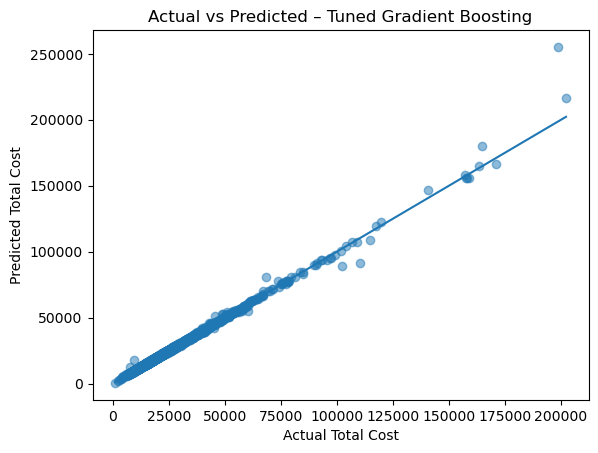

In [18]:
# Actual vs Predicted
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_gbr_tuned, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Actual Total Cost")
plt.ylabel("Predicted Total Cost")
plt.title("Actual vs Predicted – Tuned Gradient Boosting")
plt.show()

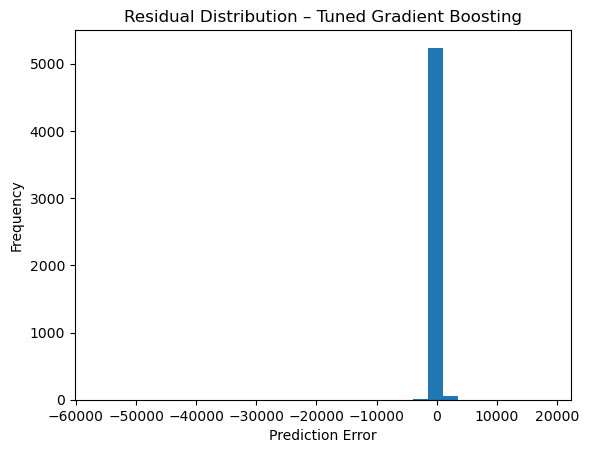

In [19]:
# Residual Distribution
residuals = y_test - y_pred_gbr_tuned

plt.hist(residuals, bins=30)
plt.title("Residual Distribution – Tuned Gradient Boosting")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()

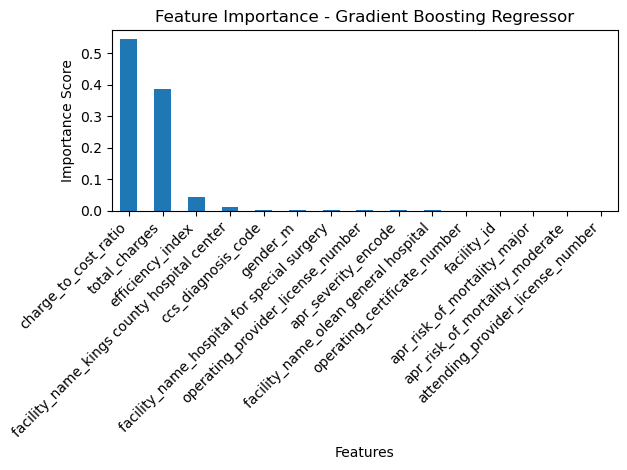

In [20]:
# Get feature importance
feature_importance = pd.Series(
    best_gbr.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# Plot
plt.figure()
feature_importance.head(15).plot(kind="bar")
plt.title("Feature Importance - Gradient Boosting Regressor")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### MODEL 2

In [21]:
# XGBoost Regressor
# Import Libraries
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [22]:
# Baseline XGBoost Model

xgb_base = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_base.fit(X_train, y_train)

y_pred_xgb_base = xgb_base.predict(X_test)

In [23]:
# Baseline Metrics
rmse_xgb_base = np.sqrt(mean_squared_error(y_test, y_pred_xgb_base))
mae_xgb_base = mean_absolute_error(y_test, y_pred_xgb_base)
mape_xgb_base = np.mean(np.abs((y_test - y_pred_xgb_base) / y_test)) * 100

print("Baseline XGBoost Performance")
print(f"RMSE : {rmse_xgb_base:.2f}")
print(f"MAE  : {mae_xgb_base:.2f}")
print(f"MAPE : {mape_xgb_base:.2f}%")

Baseline XGBoost Performance
RMSE : 1466.94
MAE  : 338.87
MAPE : 1.38%


In [24]:
# Hyperparameter Tuning

param_grid_xgb = {
    "n_estimators": [200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42
)

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid_xgb,
    n_iter=15,
    scoring="neg_root_mean_squared_error",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_random.fit(X_train, y_train)

best_xgb = xgb_random.best_estimator_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [25]:
# Tuned XGBoost Predictions

y_pred_xgb_tuned = best_xgb.predict(X_test)

In [26]:
# Metrics
rmse_xgb_tuned = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuned))
mae_xgb_tuned = mean_absolute_error(y_test, y_pred_xgb_tuned)
mape_xgb_tuned = np.mean(np.abs((y_test - y_pred_xgb_tuned) / y_test)) * 100

print("Tuned XGBoost Performance")
print(f"RMSE : {rmse_xgb_tuned:.2f}")
print(f"MAE  : {mae_xgb_tuned:.2f}")
print(f"MAPE : {mape_xgb_tuned:.2f}%")

Tuned XGBoost Performance
RMSE : 1346.78
MAE  : 295.14
MAPE : 1.20%


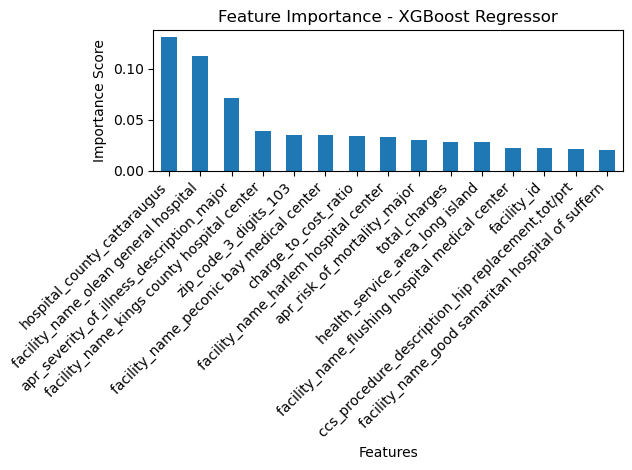

In [27]:
# Feature Importance Plot
feature_importance_xgb = pd.Series(
    best_xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure()
feature_importance_xgb.head(15).plot(kind="bar")
plt.title("Feature Importance - XGBoost Regressor")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

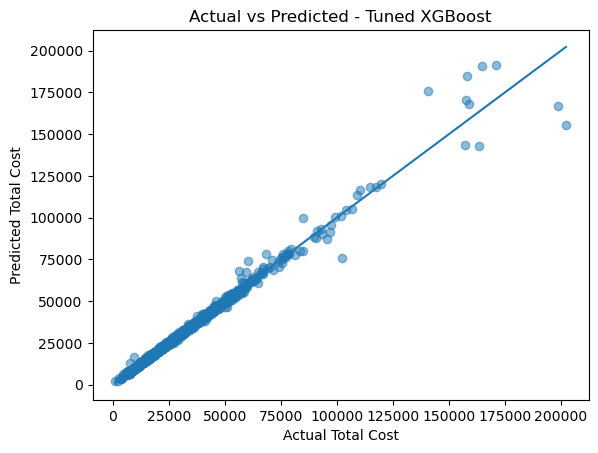

In [ ]:
# Actual vs Predicted Plot
plt.figure()
plt.scatter(y_test, y_pred_xgb_tuned, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Actual Total Cost")
plt.ylabel("Predicted Total Cost")
plt.title("Actual vs Predicted - Tuned XGBoost")
plt.show()

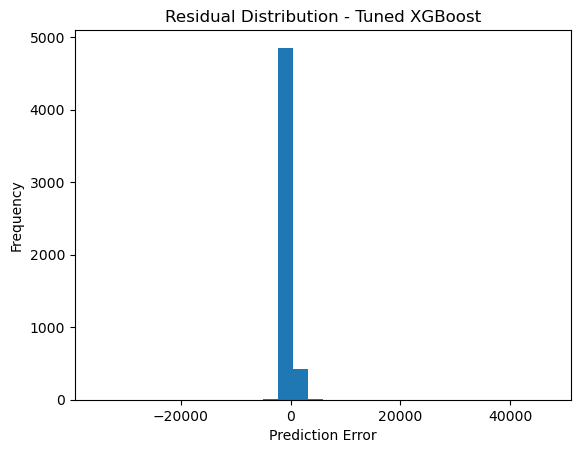

In [29]:
# Residual Distribution Plot
residuals_xgb = y_test - y_pred_xgb_tuned

plt.figure()
plt.hist(residuals_xgb, bins=30)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Residual Distribution - Tuned XGBoost")
plt.show()

#### Model Summary

##### Overview

As part of ML Task 2 – Total Cost Prediction, focused on building advanced boosting-based regression models to accurately forecast patient-level healthcare costs. Two models were developed and evaluated: Gradient Boosting Regressor (GBR) and XGBoost Regressor (XGB). These models are well-suited for capturing complex, non-linear relationships commonly observed in healthcare cost data.

##### Gradient Boosting Regressor (GBR)

The Gradient Boosting Regressor was implemented as a sequential ensemble model where each new tree attempts to correct the errors made by previous trees. This approach allowed the model to learn intricate cost patterns influenced by demographic, clinical, and admission-related features. Hyperparameter tuning was performed using RandomizedSearchCV, resulting in improved generalization compared to the baseline model. Feature importance analysis revealed key cost-driving variables, providing interpretability and actionable insights for hospital decision-makers.

Key Strengths:

Strong performance on non-linear cost relationships

Interpretable feature importance

Stable and robust after tuning

##### XGBoost Regressor (XGB)

XGBoost was employed as a more advanced boosting technique, incorporating regularization, efficient tree construction, and optimized handling of variance and noise. After hyperparameter tuning, XGBoost demonstrated superior predictive capability, achieving lower error metrics (RMSE, MAE, MAPE) compared to Gradient Boosting. Diagnostic plots such as residual distributions and actual vs predicted cost charts confirmed that the model generalizes well to unseen data. Feature importance results further helped identify high-impact cost drivers.

Key Strengths:

High predictive accuracy

Excellent handling of complex interactions

Reduced overfitting due to regularization

##### Final Conclusion

Among the two boosting-based models, XGBoost Regressor emerged as the best-performing model for total cost prediction due to its lower error rates and stronger generalization ability. Both models, however, provide valuable insights into healthcare cost drivers and can support hospitals in budget forecasting, early identification of high-cost patients, and resource optimization. The findings from Team B contribute significantly to the overall model comparison and final deployment decision for the EffiCare Healthcare Analytics Project.